#Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn_pandas

#Reading the Investment Data files

In [ ]:
#investmentdata = pd.read_csv("investments_VC.csv",encoding='latin1')
investmentdata = pd.read_csv("investments_VC.csv",encoding='ISO-8859-1')

Here are the data points in the file and what they mean:
1. permalink: URL of the organization
2. name: Name of the organization
3. homepage_url: Website URL of the organization
4. category_list: List of categories the organization belongs to
5. market: The market the organization operates in
6. funding_total_usd: Total funding received by the organization in USD  
7. status: Current status of the organization (e.g., operating, acquired)  
8. country_code, state_code, region, city: Geographical details of the organization  
9. founded_at: The date when the organization was founded   
10. funding_rounds: Number of funding rounds the organization went through
11. Various columns related to the amount of funding received in different rounds (e.g., seed, venture, round_A, round_B)

Lets set the display option to decimal format vs scientific format which is default

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

Checking to see if we are able to load all the columns correctly

##Test

In [ ]:
#display(investmentdata.info())
#print(investmentdata.head())
print(investmentdata.describe())

       funding_rounds  founded_year         seed       venture  \
count        49438.00      38482.00     49438.00      49438.00   
mean             1.70       2007.36    217321.50    7501050.54   
std              1.29          7.58   1056984.82   28471124.16   
min              1.00       1902.00         0.00          0.00   
25%              1.00       2006.00         0.00          0.00   
50%              1.00       2010.00         0.00          0.00   
75%              2.00       2012.00     25000.00    5000000.00   
max             18.00       2014.00 130000000.00 2351000000.00   

       equity_crowdfunding  undisclosed  convertible_note  debt_financing  \
count             49438.00     49438.00          49438.00        49438.00   
mean               6163.32    130221.28          23364.10      1888156.89   
std              199904.82   2981403.65        1432045.73    138204566.17   
min                   0.00         0.00              0.00            0.00   
25%                 

In [ ]:
#investmentdata.drop_duplicates(subset=['homepage_url'],inplace=True)
#investmentdata.drop(['permalink','homepage_url','category_list'],axis=1,inplace=True)
#display(investmentdata.info())
#print(investmentdata.head())
#print(investmentdata.describe())

Lets do some analysis on the data, so we can figure out what kind of cleaning and normalization is required

In [ ]:
data_summary = pd.DataFrame({
    'Data Type' : investmentdata.dtypes,
    'Missing Values ': investmentdata.isnull().sum(),
    'Unique Values ' : investmentdata.nunique(),
    'First Record ' : investmentdata.iloc[0]
    })

print(data_summary)

                     Data Type  Missing Values   Unique Values   \
permalink               object             4856           49436   
name                    object             4857           49350   
homepage_url            object             8305           45850   
category_list           object             8817           16675   
 market                 object             8824             753   
 funding_total_usd      object             4856           14617   
status                  object             6170               3   
country_code            object            10129             115   
state_code              object            24133              61   
region                  object            10129            1089   
city                    object            10972            4188   
funding_rounds         float64             4856              17   
founded_at              object            15740            3369   
founded_month           object            15812             42

Before we do further analysis, lets remove any duplicate entries in the data. If the webpage specified is the same then we can assume that they are the same records

In [ ]:
#print(investmentdata.describe())
investmentdata.drop_duplicates(subset=['homepage_url'],inplace=True)
#print(investmentdata.describe())

So looks like we went from 49438 records to 45851 records after applying homepage_url duplicate check.

Now we can try to explore the data that is cleaner. Lets start with distribution of the companies by status (operating, acquired or closed)

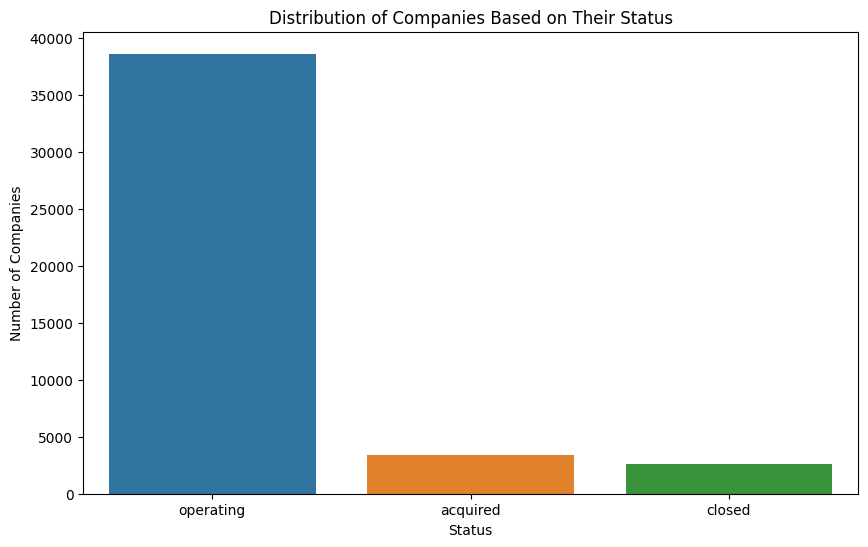

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=investmentdata, x='status', order=investmentdata['status'].value_counts().index)
plt.title('Distribution of Companies Based on Their Status')
plt.ylabel('Number of Companies')
plt.xlabel('Status')
plt.show()

It looks like most of the companies from the dataset are operating and acuqired and closed companies are small part of the dataset

Now lets analyze the data based on other column to see if anything stands out, lets use countries in which the companies have been operating/founded.

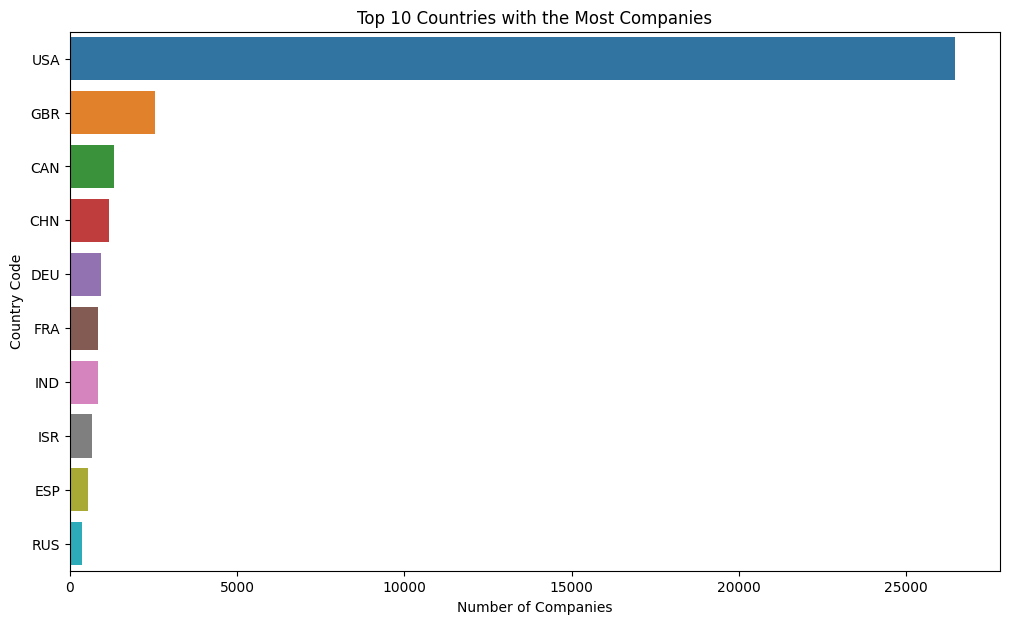

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=investmentdata, y='country_code', order=investmentdata['country_code'].value_counts().iloc[:10].index)
plt.title('Top 10 Countries with the Most Companies')
plt.xlabel('Number of Companies')
plt.ylabel('Country Code')
plt.show()

It seems that bulk of startup that are launched are from US.

Now lets explore funding statistics to see if anything stands out

In [ ]:
# identifying the correct column name for funding_total_usd
funding_column = [col for col in investmentdata.columns if "funding_total_usd" in col][0]

# converting the column to numeric after removing commas
investmentdata[funding_column] = pd.to_numeric(investmentdata[funding_column].str.replace(',', '').replace(' -   ', np.nan), errors='coerce')
#investmentdata[funding_column] = investmentdata[funding_column].str.replace(',', '').astype(float)

# summary statistics of the total funding in USD
funding_summary = investmentdata[funding_column].describe()

funding_summary

count         38470.00
mean       16247844.81
std       173293648.00
min               1.00
25%          350000.00
50%         2000000.00
75%        10000000.00
max     30079503000.00
Name:  funding_total_usd , dtype: float64

It looks like there are some funding numbers that skewing the data, lets remove the outlier using IQR method

In [ ]:
# calculating IQR for the funding_total_usd column
Q1 = investmentdata[funding_column].quantile(0.25)
Q3 = investmentdata[funding_column].quantile(0.75)
IQR = Q3 - Q1

# defining the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filtering the data to remove outliers
filtered_data = investmentdata[(investmentdata[funding_column] >= lower_bound) & (investmentdata[funding_column] <= upper_bound)]

# summary statistics of the filtered funding data
filtered_funding_summary = filtered_data[funding_column].describe()

filtered_funding_summary

count      33432.00
mean     3830504.00
std      5383767.53
min            1.00
25%       250000.00
50%      1308878.00
75%      5000000.00
max     24425000.00
Name:  funding_total_usd , dtype: float64

It looks like removing the outliers seem to reduce the mean, std and other stats. Now lets explore some of the other columns to see if any insight can be gained. Lets look at market, funding rounds and funding from different rounds.

In [ ]:
# identifying the correct column names
market_column = [col for col in filtered_data.columns if "market" in col.lower()][0]
funding_rounds_column = [col for col in filtered_data.columns if "funding_rounds" in col.lower()][0]

# exploring the 'market' column
market_counts = filtered_data[market_column].value_counts().head(10)  # Top 10 markets

# exploring the 'funding_rounds' column
funding_rounds_counts = filtered_data[funding_rounds_column].value_counts()

# list of potential funding round columns
funding_features = ['seed', 'venture', 'round_A', 'round_B', 'round_C', 'round_D']

# identifying actual column names for funding rounds from the dataset
funding_features_actual = [col for col in filtered_data.columns if any(round_name in col.lower() for round_name in funding_features)]

# exploring the 'market' column
market_counts = filtered_data[market_column].value_counts().head(10)  # Top 10 markets

# exploring the 'funding_rounds' column
funding_rounds_counts = filtered_data[funding_rounds_column].value_counts()

# exploring funding amounts from different rounds
funding_summaries = filtered_data[funding_features_actual].describe()

market_counts, funding_rounds_counts, funding_summaries


( Software                3445
  Biotechnology           2403
  Mobile                  1469
  E-Commerce              1247
  Curated Web             1224
  Enterprise Software      924
  Hardware + Software      823
  Games                    823
  Health Care              771
  Advertising              764
 Name:  market , dtype: int64,
 1.00     21004
 2.00      7472
 3.00      2961
 4.00      1157
 5.00       457
 6.00       211
 7.00        82
 8.00        38
 9.00        27
 10.00        9
 11.00        5
 12.00        3
 14.00        2
 13.00        2
 16.00        1
 15.00        1
 Name: funding_rounds, dtype: int64,
              seed     venture
 count    33432.00    33432.00
 mean    281122.98  3035465.84
 std     725283.86  5137824.18
 min          0.00        0.00
 25%          0.00        0.00
 50%          0.00   135000.00
 75%     135043.00  4000000.00
 max   21000000.00 24425000.00)

Market: The top markets where startups operate include Software, Biotechnology, Mobile, E-Commerce, and Curated Web. These markets have the highest number of startups in our filtered dataset.

Funding Rounds: A significant majority of startups have just one funding round.The number of startups decreases sharply as the number of funding rounds increases.

Funding Amounts from Different Rounds: From our filtered data, we have information on the seed and venture rounds. For the seed round, the average funding amount is approximately \$281,122, with a maximum of \$21 million. For the venture round, the average funding amount is approximately \$3.03 million, with a maximum of \$24.425 million.

Lets see what data looks like if we remove outliers from seed and venture rounds

In [ ]:
# removing outliers for 'seed' round
Q1_seed = filtered_data['seed'].quantile(0.25)
Q3_seed = filtered_data['seed'].quantile(0.75)
IQR_seed = Q3_seed - Q1_seed

lower_bound_seed = Q1_seed - 1.5 * IQR_seed
upper_bound_seed = Q3_seed + 1.5 * IQR_seed

# removing outliers for 'venture' round
Q1_venture = filtered_data['venture'].quantile(0.25)
Q3_venture = filtered_data['venture'].quantile(0.75)
IQR_venture = Q3_venture - Q1_venture

lower_bound_venture = Q1_venture - 1.5 * IQR_venture
upper_bound_venture = Q3_venture + 1.5 * IQR_venture

# filtering the data to remove outliers for both rounds
filtered_data_no_outliers = filtered_data[(filtered_data['seed'] >= lower_bound_seed) & (filtered_data['seed'] <= upper_bound_seed) &
                                          (filtered_data['venture'] >= lower_bound_venture) & (filtered_data['venture'] <= upper_bound_venture)]

# checking the shape of the data after removing outliers
filtered_data_no_outliers.shape

# exploring funding amounts from different rounds
funding_no_outliers_summaries = filtered_data_no_outliers[funding_features_actual].describe()

market_counts, funding_rounds_counts, funding_no_outliers_summaries

( Software                3445
  Biotechnology           2403
  Mobile                  1469
  E-Commerce              1247
  Curated Web             1224
  Enterprise Software      924
  Hardware + Software      823
  Games                    823
  Health Care              771
  Advertising              764
 Name:  market , dtype: int64,
 1.00     21004
 2.00      7472
 3.00      2961
 4.00      1157
 5.00       457
 6.00       211
 7.00        82
 8.00        38
 9.00        27
 10.00        9
 11.00        5
 12.00        3
 14.00        2
 13.00        2
 16.00        1
 15.00        1
 Name: funding_rounds, dtype: int64,
            seed     venture
 count  23885.00    23885.00
 mean   28864.72  1735956.67
 std    65711.09  2655097.80
 min        0.00        0.00
 25%        0.00        0.00
 50%        0.00   125000.00
 75%    19713.00  2600000.00
 max   337471.00 10000000.00)

After removing outliers, looks like numbers improved, here is the summary of what it looks like:

Market: The top markets where startups operate include Software, Biotechnology, Mobile, E-Commerce, and Curated Web. These markets have the highest number of startups in our filtered dataset.

Funding Rounds: A significant majority of startups have just one funding round.The number of startups decreases sharply as the number of funding rounds increases.

Funding Amounts from Different Rounds: From our filtered data, we have information on the seed and venture rounds. For the seed round, the average funding amount is approximately \$28,864, with a maximum of \$3.3 million. For the venture round, the average funding amount is approximately \$17.3 million, with a maximum of \$10 million.

Now lets do some pre-processing to handle, missing values, convert categorical values to numerical format and scale numerical values to prepare the data for machine learning

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# handling missing values: filling NA values with 'Unknown' for 'market' and 0 for numerical columns
filtered_data_no_outliers[market_column].fillna('Unknown', inplace=True)
filtered_data_no_outliers[funding_features_actual].fillna(0, inplace=True)

# one-hot encoding the 'market' column
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_market = encoder.fit_transform(filtered_data_no_outliers[[market_column]])
encoded_market_df = pd.DataFrame(encoded_market, columns=encoder.get_feature_names_out([market_column]), index=filtered_data_no_outliers.index)

# scaling the numerical features
scaler = StandardScaler()
scaled_funding = scaler.fit_transform(filtered_data_no_outliers[funding_features_actual])
scaled_funding_df = pd.DataFrame(scaled_funding, columns=funding_features_actual, index=filtered_data_no_outliers.index)

# combining the preprocessed features
preprocessed_data = pd.concat([scaled_funding_df, encoded_market_df], axis=1)

filtered_data_no_outliers = filtered_data_no_outliers[(filtered_data_no_outliers['status'] != 'closed') & (~filtered_data_no_outliers[' funding_total_usd '].isnull())]
filtered_data_no_outliers['success'] = filtered_data_no_outliers['status'].apply(lambda x: 1 if x in ['operating', 'acquired'] else 0)

# checking the first few rows of the preprocessed data
preprocessed_data.head()

<ipython-input-30-331ed9c7b200>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_no_outliers[market_column].fillna('Unknown', inplace=True)
<ipython-input-30-331ed9c7b200>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_no_outliers[funding_features_actual].fillna(0, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-30-331ed9c7b200>:21: SettingWit

,seed,venture,market _ 3D Printing,market _ 3D Technology,market _ Accounting,market _ Ad Targeting,market _ Adventure Travel,market _ Advertising,market _ Advertising Exchanges,market _ Advertising Networks,...,market _ Wine And Spirits,market _ Wireless,market _ Women,market _ World Domination,market _ iOS,market _ iPad,market _ iPhone,market _ iPod Touch,market _ mHealth,market _Unknown
1,-0.44,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.17,-0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.44,-0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-0.44,1.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,-0.44,-0.65,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# remove spaces from column names
filtered_data_no_outliers.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

************************************************************** ML Starts *************************************

This is good starting point to use the data for Machine Learning so lets save this cleaned data in new file

In [ ]:
filtered_data_no_outliers.to_csv('filter_no_outliers.csv',index=False)
#preprocessed_data.to_csv('clean_investmentdata.csv',index=False)